# Cropped Images Methodology

Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import numpy as np
from numpy import expand_dims
import argparse
import os
import glob
import xmltodict
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET # copy of xml
from xml.etree.ElementTree import parse
import cv2
from skimage import io
from scipy.signal import convolve2d
from PIL import Image  
import PIL 
import urllib
from urllib.request import urlopen
from typing import Tuple, List, Dict
from bs4 import BeautifulSoup
import requests
from io import BytesIO
from keras.applications import MobileNetV2
from keras import layers
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator # load the image
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from keras.utils import to_categorical
from keras import backend as K
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import seaborn as sns 
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
import tensorflow as tf
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
from keras.models import Sequential
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

### Detect helmets using bounding box

* A different approach is to do the helmet detection using the bounding box.

* Once we know where the upperbody is in the image, using the bounding box, we can extract the cropped picture of the upper body. From there, we can apply the model for cropped images helmet detection, to predict and classify each motorcyclist seperately.


Data Pre-processing

#### URLs for images and annotations

In [3]:
prefix_url_imgs = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/"
number_of_imgs = 766 # +1 to include last one (765)

list_imgs = []

for i in range(0, number_of_imgs):
    i = str(i)
    var_imgs = "BikesHelmets" + i + ".png"
    var_imgs_url = prefix_url_imgs + var_imgs
    list_imgs.append(var_imgs_url)

In [4]:
prefix_url_xml = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/annotations/"
number_of_annt = 766 # +1 to include last one (765)

list_annotations= []

for i in range(0, number_of_annt):
    i = str(i)
    var_annt = "BikesHelmets" + i + ".xml"
    var_annt_url = prefix_url_xml + var_annt
    list_annotations.append(var_annt_url)

### Images load
* Retrieving and labelling images from XML annotations
* Based on annotations if a pearson wears a helmet the label would be 1, otherwise the label would be 0


In [5]:
cropped_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            image = cv2.cvtColor(np.array(img_temp), cv2.INPAINT_TELEA)
            helmet = np.zeros(image.shape, dtype = 'int32')

            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        xmin = int(i['bndbox']['xmin'])
                        ymin = int(i['bndbox']['ymin'])
                        xmax = int(i['bndbox']['xmax'])
                        ymax = int(i['bndbox']['ymax'])
                        if i['name'] == 'With Helmet':
                            helmet = cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3) #with helmet -> 1
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                            #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                            
                        else:
                            cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                            
                            #plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                if isinstance(tags['object'], dict):
                    xmin = int(tags['object']['bndbox']['xmin'])
                    ymin = int(tags['object']['bndbox']['ymin'])
                    xmax = int(tags['object']['bndbox']['xmax'])
                    ymax = int(tags['object']['bndbox']['ymax'])
                    if tags['object']['name'] == 'With Helmet':
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path]) #with helmet -> 1
                        #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                    else:
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                    # plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
    except:
        pass

Data Reshaping

In [6]:
from tensorflow.keras.preprocessing.image import array_to_img
all_cropped_imgs_v2 = []
for i in range(1, len(cropped_imgs)):
    try:
        img_temp = array_to_img(cropped_imgs[i][1])
        resized = img_temp.resize((120,120)) # resize all images to 40x40
        image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
        all_cropped_imgs_v2.append([cropped_imgs[i][0], image, cropped_imgs[i][2], cropped_imgs[i][3]])
    except:
        pass

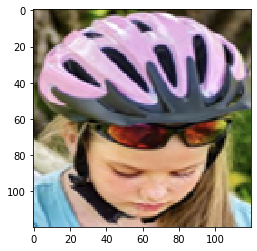

In [7]:
plt.imshow(all_cropped_imgs_v2[1110][1], interpolation='nearest')

In [8]:
# Transforming images in a proper array for model input
cropped_imgs_array = []
for i in range(0, len(all_cropped_imgs_v2)):
    cropped_imgs_array.append(np.array(all_cropped_imgs_v2[i][1]))
    
cropped_imgs_array = np.array(cropped_imgs_array, dtype='int')

# Creating an array with labels
labels_array_cropped = []
for i in range(0, len(all_cropped_imgs_v2)):
    labels_array_cropped.append(np.array(all_cropped_imgs_v2[i][2]))
  
labels_array_cropped = np.array(labels_array_cropped, dtype='int')

# Categorically encode the labels
cropped_imgs_labels = to_categorical(labels_array_cropped)

Data Reshaping and Normalization

In [10]:
def reshape_img_input(x: np.ndarray,
                      img_rows: int = 224,
                      img_cols: int = 224,
                      normalize: bool = True) -> Tuple:
        
    print(f'Original shape of nd-array: {x.shape}')
    
    if K.image_data_format() == 'channels_first':
        
        # the channel dimension goes to the front
        x1 = x.reshape(x.shape[0], 3, img_rows, img_cols)

        input_shape = (3, img_rows, img_cols)

    else:
        # the channel dimension goes to the end. So we end up with the following 4-D tensor
        # (N-samples, Height, Width, N-channels)
        x1 = x.reshape(x.shape[0], img_rows, img_cols, 3)

        input_shape = (img_rows, img_cols, 3)

    x1 = x1.astype('float32')

    if normalize:
        x1 /= 255.
        
    return x1, input_shape

In [11]:
data_cropped, input_shape_cr = reshape_img_input(x=cropped_imgs_array,
                                         img_rows=120, 
                                         img_cols=120,
                                         normalize=True)

Original shape of nd-array: (1431, 120, 120, 3)


Train, Test and Validation Spit

In [12]:
from sklearn.model_selection import train_test_split
X_train_cr, X_test_1_cr, y_train_cr, y_test_1_cr = train_test_split(data_cropped, cropped_imgs_labels,
                                                    stratify=cropped_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test_cr, X_val_cr, y_test_cr, y_val_cr = train_test_split(X_test_1_cr, y_test_1_cr,
                                                    stratify=y_test_1_cr, 
                                                    test_size=0.25, random_state=5)

In [13]:
X_test_cr[1].shape

(120, 120, 3)

Fitting InceptionV3 Model on cropped images

In [20]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
import tensorflow as tf
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import Sequential
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Setting the Hyperparameters

In [25]:
learning_Rate = 1e-3
num_Epochs = 50
batch_Size = 32
steps_per_Epoch = int(len(X_train_cr) / batch_Size)

Early Stopping

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1, restore_best_weights = True)

Reduce Learning Rate On Plateau

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.1, min_lr = 1e-6)

InceptionV3 model

In [21]:
inceptv3 = InceptionV3(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False 
)

for layer in inceptv3.layers:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x = inceptv3(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
inception_v3 = Model(inputs, outputs)

inception_v3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
inceptv3_cropped = InceptionV3(
    weights = "imagenet",
    input_shape = (120, 120, 3),
    include_top = False 
)

for layer in inceptv3_cropped.layers:
    layer.trainable = False

inputs = Input(shape=(120, 120, 3))
x = inceptv3_cropped(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
inception_v3_cropped = Model(inputs, outputs)

inception_v3_cropped.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [28]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
inception_v3_cropped.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

In [29]:
model_cropped = inception_v3_cropped.fit(
                    x = X_train_cr,
                    y = y_train_cr,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val_cr, y_val_cr),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
33/33 [==============================] - 20s 488ms/step - loss: 3.2876 - accuracy: 0.7898 - recall: 0.7898 - precision: 0.7898 - auc: 0.8256 - val_loss: 0.7898 - val_accuracy: 0.9111 - val_recall: 0.9111 - val_precision: 0.9111 - val_auc: 0.9511 - lr: 0.0100
Epoch 2/50
33/33 [==============================] - 14s 416ms/step - loss: 1.1822 - accuracy: 0.8982 - recall: 0.8982 - precision: 0.8982 - auc: 0.9269 - val_loss: 1.3781 - val_accuracy: 0.8889 - val_recall: 0.8889 - val_precision: 0.8889 - val_auc: 0.9091 - lr: 0.0100
Epoch 3/50
33/33 [==============================] - 13s 385ms/step - loss: 0.7304 - accuracy: 0.9222 - recall: 0.9222 - precision: 0.9222 - auc: 0.9550 - val_loss: 0.6098 - val_accuracy: 0.9111 - val_recall: 0.9111 - val_precision: 0.9111 - val_auc: 0.9456 - lr: 0.0100
Epoch 4/50
33/33 [==============================] - 14s 420ms/step - loss: 0.3168 - accuracy: 0.9481 - recall: 0.9481 - precision: 0.9481 - auc: 0.9756 - val_loss: 0.7268 - val_accuracy: 0.9

Model's Performance

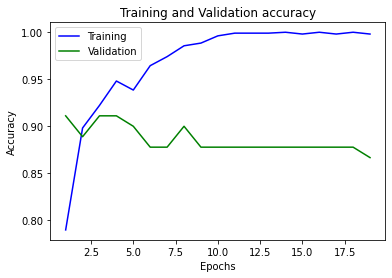

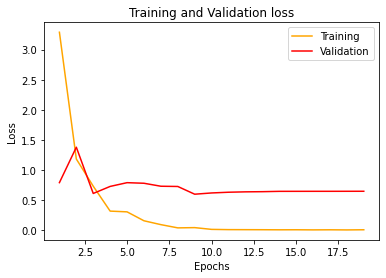

In [30]:
loss = model_cropped.history['loss']
val_loss = model_cropped.history['val_loss']
acc = model_cropped.history['accuracy']
val_acc = model_cropped.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
y_true = np.argmax(y_test_cr, axis = 1)[:]
pred = inception_v3_cropped.predict(X_test_cr, verbose = 0) # Predict prob and get Class Indices
y_pred= np.argmax(pred, axis = 1)[:]

# calculate accuracy
acc = accuracy_score(y_pred[:], y_true[:])

print("InceptionV3 Accuracy on cropped images: {:.2%}".format(acc))

InceptionV3 Accuracy on cropped images: 91.42%


Testing the Results 



* The def function **detect_upperbody_and_helmet** has as input apart from the url of the picture (image_url) and the bounding box (box) of that. As our main goal was not to detect the upperbody in a new picture but to classify the whole picture based on the motorcyclists on this, we use as test a picture which was in our main dataset as we know the bounding boxes.

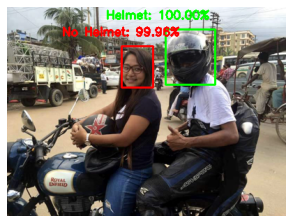

In [37]:
box=[[222,28,303,117],[159,52,214,121]]
url="https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/BikesHelmets747.png"

def detect_upperbody_and_helmet(image_url,box):

	response = requests.get(image_url)
	bytes_im = BytesIO(response.content)
	cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.INPAINT_TELEA)

	
	for i in range(0,len(box)):
	# coordinates (x, y) of the object's bounding box.
		(startX, startY, endX, endY) = box[i]

		# Select the face ROI, adjust the channel ordering from BGR to RGB, and resize it to 120, 120 pixels., and preprocess it
		face = cv_im[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.INPAINT_TELEA)
		face = cv2.resize(face, (120, 120)) #inception_v3_cropped model for cropped has as input 120x120 shape
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		#make the prediction
		inception_v3_cropped.predict(face, verbose = 0)[0]
	
		# Run the image through the model to see whether it has a helmet on it or not.
		(WithouthHelmet, Helmet) = inception_v3_cropped.predict(face, verbose = 0)[0]

		# Choose a class mark and a color to use for the bounding box and text.
		label = "Helmet" if Helmet > WithouthHelmet else "No Helmet"
		color =  (0,255,0) if label == "Helmet" else (255,0,0)

		# Show the confidence (probability) in the label.
		label = "{}: {:.2f}%".format(label, max(Helmet, WithouthHelmet) * 100)

		# On the output panel, show the mark and bounding box rectangle.
		cv2.putText(cv_im, label, (startX-80, startY - 10),
					cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
		cv2.rectangle(cv_im, (startX+5, startY+5), (endX-5, endY-5), color, 2)

	# Display the final picture
	plt.figure(figsize=(5, 5))  
	plt.axis('off')
	plt.imshow(cv_im)
	# print(WithouthHelmet)

detect_upperbody_and_helmet(url,box)
